In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import torch
print ('number of GPUs:', torch.cuda.device_count())

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt 

from minichatgpt.experiments.imdb import config, sent_kwargs
from minichatgpt import Lab
from minichatgpt.processdata.collators import imdb_dataloader_collator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
number of GPUs: 0


In [11]:
# For the sake of the speed of this demonstration, the batch_size is temporarily decreased from 256 to 4
batch_size = 8
config.batch_size = batch_size
config.forward_batch_size = batch_size//2

In [12]:
lab = Lab(config)

dataset = lab.build_dataset(dataset_name="imdb",input_min_text_length=2,input_max_text_length=8)

new_policy, old_policy, tokenizer = lab.init_policies_tokenizer()

lab.set_generation_config(do_sample=True,output_min_length=4,output_max_length=16,pad_token_id=tokenizer.eos_token_id)

ppo_trainer = lab.init_ppo_trainer(
    config, 
    new_policy, 
    old_policy, 
    tokenizer, 
    dataset, 
    dataloader_collator = imdb_dataloader_collator,
)

reward_model = lab.init_reward_model()

Found cached dataset imdb (/Users/carson/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
Loading cached processed dataset at /Users/carson/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-57d76e4722ace3a5.arrow
Loading cached processed dataset at /Users/carson/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-26d56c39f81904d0.arrow


In [13]:
returns_list = []
rewards_list = []
print(new_policy.pretrained_model.device)
print(new_policy.v_head.summary.weight.device)
#lab.reward_model.model.to('cuda:1')
#lab.reward_model.device = torch.device('cuda:1')
print(lab.reward_model.model.device)

cpu
cpu
cpu


In [17]:
for batch_step, batch in tqdm(enumerate(ppo_trainer.dataloader),total=len(ppo_trainer.dataloader)):
    
    queries = batch['input_ids']
    
    #### Get response from gpt2
    responses = []
    for query in queries:
        gen_len = lab.output_length_sampler()
        lab.generation_kwargs["max_new_tokens"] = gen_len
        response = ppo_trainer.generate(query, **lab.generation_kwargs)
        responses.append(response.squeeze()[-gen_len:])
        
    batch['response'] = [tokenizer.decode(r.squeeze()) for r in responses]
    
    #### Compute sentiment score
    texts = [q + r for q,r in zip(batch['query'], batch['response'])]
    pipe_outputs = lab.reward_model(texts, **sent_kwargs)
    
    scores = [output[1]["score"] for output in pipe_outputs]
    rewards_list.append(np.mean(scores))
    
    rewards = [torch.tensor(score) for score in scores]
    
    #### Run PPO step 
    stats = ppo_trainer.step(queries, responses, rewards)
    ppo_trainer.log_stats(stats, batch, rewards)
    
    returns_list.append(stats['ppo/returns/mean'])
    
    #break

  0%|          | 0/3112 [00:00<?, ?it/s]

KeyboardInterrupt: 

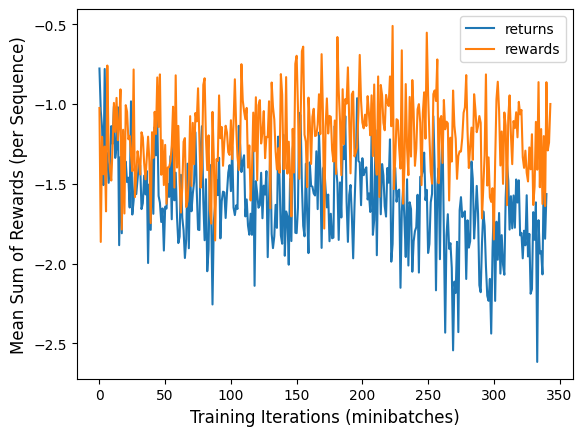

In [18]:
plt.figure()
plt.xlabel('Training Iterations (minibatches)', fontsize=12)
plt.ylabel('Mean Sum of Rewards (per Sequence)', fontsize=12)
plt.plot(returns_list, label='returns')
plt.plot(rewards_list, label='rewards')
plt.legend()
plt.show()

In [1]:
"""

device_map = {
  0: [ 0, 1, 2, 3, 4, 5],
  1: [ 6, 7, 8, 9, 10, 11],
}

new_policy.pretrained_model.parallelize(device_map)
old_policy.pretrained_model.parallelize(device_map)

print(new_policy.pretrained_model.device)
#print(new_policy.v_head)
#new_policy.v_head.summary.to('cuda:1')
print(new_policy.v_head.summary.weight.device)
#lab.reward_model.model.to('cuda:1')
#lab.reward_model.device = torch.device('cuda:1')
print(lab.reward_model.model.device)

"""

'\n\ndevice_map = {\n  0: [ 0, 1, 2, 3, 4, 5],\n  1: [ 6, 7, 8, 9, 10, 11],\n}\n\nnew_policy.pretrained_model.parallelize(device_map)\nold_policy.pretrained_model.parallelize(device_map)\n\n'